# Estimating regional fire frequency and size with MDN

Authors: Jatan Buch (v1, 210923) || (v2, 211025)

## 1 - Packages

Let's first import all the packages that we will need during this assignment.

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import ncdump, coord_transform, bailey_ecoprovince_shp, bailey_ecoprovince_mask, update_reg_indx, mon_fire_freq, mon_burned_area, tindx_func, clim_pred_var  
from stats_utils import uni_lsq_regression_model, multi_regression_model
from ml_utils import *

#Helper functions
from math import factorial
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
fire_file= data_dir + pred_input_path + "wildfire/burnarea_combined.nc"
fire_size_df= pd.read_hdf(data_dir + 'clim_fire_size_data.h5')
fire_freq_df= pd.read_hdf(data_dir + 'clim_fire_freq_data.h5')

## 2 - Training

### 2.1 Hyperparameter Tuning

To tune the hyper-parameters of our Network, we use 20% of our dataset of strictly positive burned areas.

We try multiple combinations of parameters to find out the ones that optimize the learning process and give the best accuracy.

### Fire sizes

In [9]:
df_size= fire_size_df.sample(frac=0.4)
#df_size.shape
minmax_scaler = MinMaxScaler()

X_sizes= df_size[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind', 'Elev', 'Grassland']]
X_sizes= minmax_scaler.fit_transform(X_sizes)
X_sizes= np.array(X_sizes, dtype=np.float32)

y_sizes = np.array(df_size.fire_size)

In [18]:
### code block for testing ML implementations ###

# components= 2
# neurons= 32

# opt= tf.keras.optimizers.Adam(learning_rate= 1e-2)
#mon= EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

# #mdn_size= mdn_size.reset_states()
# mdn_size= MDN_size(layers= 3, neurons=neurons, components=components)
# mdn_size.compile(loss=gpd_loss, optimizer=opt, metrics=[gpd_accuracy])
# history_sizes= mdn_size.fit(x=X_sizes, y=y_sizes, epochs=10, verbose=0);

In [17]:
size_gpd_df= hyperparam_tuning(n_layers= [2, 3, 4], n_neurons= [4, 8, 16], n_components= [1, 2, 3], X_dat= X_sizes, y_dat= y_sizes, fire_tag= 'size', func_flag= 'gpd')

  0%|          | 0/3 [00:00<?, ?it/s]

Constructing a MDN for fire size w/ 2 hidden layers


 33%|███▎      | 1/3 [04:29<08:58, 269.32s/it]

Constructing a MDN for fire size w/ 3 hidden layers


 67%|██████▋   | 2/3 [09:36<04:51, 291.70s/it]

Constructing a MDN for fire size w/ 4 hidden layers


100%|██████████| 3/3 [15:34<00:00, 311.36s/it]


In [61]:
size_gpd_df

,n_components,n_layers,n_neurons,Loss,Accuracy
0,1,2,4,3.079071,78.415932
1,2,2,4,3.083551,78.209236
2,3,2,4,3.064302,83.985687
3,1,2,8,3.064096,77.408104
4,2,2,8,3.051591,84.652336
5,3,2,8,3.038993,84.614708
6,1,2,16,3.056325,78.147217
7,2,2,16,3.040285,78.294884
8,3,2,16,3.038890,84.644676
9,1,3,4,3.084338,78.526581


In [18]:
size_lognorm_df= hyperparam_tuning(n_layers= [2, 3, 4], n_neurons= [4, 8, 16], n_components= [2, 3, 4], X_dat= X_sizes, y_dat= y_sizes, fire_tag= 'size', func_flag= 'lognorm')

  0%|          | 0/3 [00:00<?, ?it/s]

Constructing a MDN for fire size w/ 2 hidden layers


 33%|███▎      | 1/3 [04:45<09:30, 285.23s/it]

Constructing a MDN for fire size w/ 3 hidden layers


 67%|██████▋   | 2/3 [10:38<05:24, 324.97s/it]

Constructing a MDN for fire size w/ 4 hidden layers


100%|██████████| 3/3 [17:18<00:00, 346.31s/it]


In [32]:
gpd_params= pow(size_gpd_df['n_neurons'], 2)*size_gpd_df['n_layers'] + size_gpd_df['n_components']
gpd_opt_config= np.argmin(size_gpd_df['Loss']*gpd_params/size_gpd_df['Accuracy'])
size_gpd_df.iloc[gpd_opt_config]

n_components     3.000000
n_layers         2.000000
n_neurons        4.000000
Loss             3.064302
Accuracy        83.985687
Name: 2, dtype: float64

In [33]:
lognorm_params= pow(size_lognorm_df['n_neurons'], 2)*size_lognorm_df['n_layers'] + size_lognorm_df['n_components']
lognorm_opt_config= np.argmin(size_lognorm_df['Loss']*lognorm_params/size_lognorm_df['Accuracy'])
size_lognorm_df.iloc[lognorm_opt_config]

n_components     2.000000
n_layers         2.000000
n_neurons        4.000000
Loss             3.075971
Accuracy        81.338860
Name: 0, dtype: float64

### Fire frequency

In [12]:
df_freq= fire_freq_df.sample(frac=0.4)
minmax_scaler = MinMaxScaler()

X_freqs = df_freq[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind','Grassland']]
X_freqs= minmax_scaler.fit_transform(X_freqs)
X_freqs= np.array(X_freqs, dtype=np.float32)

y_freqs = np.array(df_freq.fire_freq)
y_freqs= y_freqs.astype('float32')

In [20]:
freq_zinb_df= hyperparam_tuning(n_layers= [2, 3, 4], n_neurons= [4, 8, 16], X_dat= X_freqs, y_dat= y_freqs, fire_tag= 'freq', func_flag= 'zinb')

  0%|          | 0/3 [00:00<?, ?it/s]

Constructing a MDN for fire freq w/ 2 hidden layers


 33%|███▎      | 1/3 [00:34<01:09, 34.87s/it]

Constructing a MDN for fire freq w/ 3 hidden layers


 67%|██████▋   | 2/3 [01:21<00:42, 42.02s/it]

Constructing a MDN for fire freq w/ 4 hidden layers


100%|██████████| 3/3 [02:02<00:00, 40.73s/it]


In [21]:
freq_zinb_df

,n_layers,n_neurons,Loss,Accuracy
0,2,4,1.585279,91.862511
1,2,8,1.519987,91.046509
2,2,16,1.398187,92.559624
3,3,4,1.756783,91.075195
4,3,8,1.504631,91.906097
5,3,16,1.427712,91.148491
6,4,4,1.580838,91.457329
7,4,8,1.523794,90.910049
8,4,16,1.370654,92.187531


Based on the above results, our hyperparameter choices are as follows:
* MDN_Size: 3 mixture components modeled using a NN w/ 2 hidden layers that consist of 4 neurons each,
* MDN_Freq: 2 hidden layers with 16 neurons each

## 3 - Testing

### 3.1 Data pre-processing

In [3]:
fire_size_train= fire_size_df[fire_size_df.month < 372] # for Training and Testing; 372 ==> Jan. 2015; ensures ~80/20 training-prediction split
fire_size_test= fire_size_df[fire_size_df.month >= 372] # for Prediction

minmax_scaler = MinMaxScaler()

X_size_train_df= fire_size_train[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind', 'Elev', 'Grassland']]
X_size_train_df= minmax_scaler.fit_transform(X_size_train_df)
X_size_train= np.array(X_size_train_df, dtype=np.float32)
y_size_train= np.array(fire_size_train.fire_size, dtype=np.float32)

X_size_test_df= fire_size_test[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind', 'Elev', 'Grassland']]
X_size_test_df= minmax_scaler.fit_transform(X_size_test_df)
X_sizes_test= np.array(X_size_test_df, dtype=np.float32)
y_sizes_test= np.array(fire_size_test.fire_size, dtype=np.float32)

#splitting only the training data set
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val = train_test_split(X_size_train, y_size_train, test_size=0.3, random_state=56)

In [4]:
fire_freq_train= fire_freq_df[fire_freq_df.month < 372] # for Training and Testing; 372 ==> Jan. 2015; ensures ~80/20 training-prediction split
fire_freq_test= fire_freq_df[fire_freq_df.month >= 372] # for Prediction

minmax_scaler = MinMaxScaler()

X_freq_train_df= fire_freq_train[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind', 'Grassland']]
X_freq_train_df= minmax_scaler.fit_transform(X_freq_train_df)
X_freq_train= np.array(X_freq_train_df, dtype=np.float32)
y_freq_train= np.array(fire_freq_train.fire_freq, dtype=np.float32)

X_freq_test_df= fire_freq_test[['Tmax', 'VPD', 'Prec', 'Antprec', 'ETo', 'Forest', 'Solar', 'Wind', 'Grassland']]
X_freq_test_df= minmax_scaler.fit_transform(X_freq_test_df)
X_freqs_test= np.array(X_freq_test_df, dtype=np.float32)
y_freqs_test= np.array(fire_freq_test.fire_freq, dtype=np.float32)

#splitting only the training data set
X_freqs_train, X_freqs_val, y_freqs_train, y_freqs_val = train_test_split(X_freq_train, y_freq_train, test_size=0.3, random_state=65)

### 3.2 Validation

#### Fire sizes

In [48]:
gpd_train_acc, gpd_val_acc, gpd_train_loss, gpd_val_loss, gpd_acc_iter, gpd_val_acc_iter, gpd_loss_iter, gpd_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 4, n_components= 3, X_dat= X_sizes_train, y_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                      y_val_dat= y_sizes_val, fire_tag= 'size', func_flag= 'gpd')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire size MDN with gpd loss function


 20%|██        | 1/5 [00:36<02:27, 36.94s/it]

Validation iteration 2 for fire size MDN with gpd loss function


 40%|████      | 2/5 [01:10<01:44, 34.84s/it]

Validation iteration 3 for fire size MDN with gpd loss function


 60%|██████    | 3/5 [01:42<01:07, 33.77s/it]

Validation iteration 4 for fire size MDN with gpd loss function


 80%|████████  | 4/5 [02:14<00:33, 33.14s/it]

Validation iteration 5 for fire size MDN with gpd loss function


100%|██████████| 5/5 [02:52<00:00, 34.45s/it]


In [12]:
print('Training Loss: ', np.nanmean(gpd_loss_iter))
print('Validation Loss: ', np.nanmean(gpd_val_loss_iter))
print('Training Accuracy: ', np.nanmean(gpd_acc_iter))
print('Validation Accuracy: ', np.nanmean(gpd_val_acc_iter))

Training Loss:  2.9877208709716796
Validation Loss:  3.0091198921203612
Training Accuracy:  84.54798431396485
Validation Accuracy:  83.5748306274414


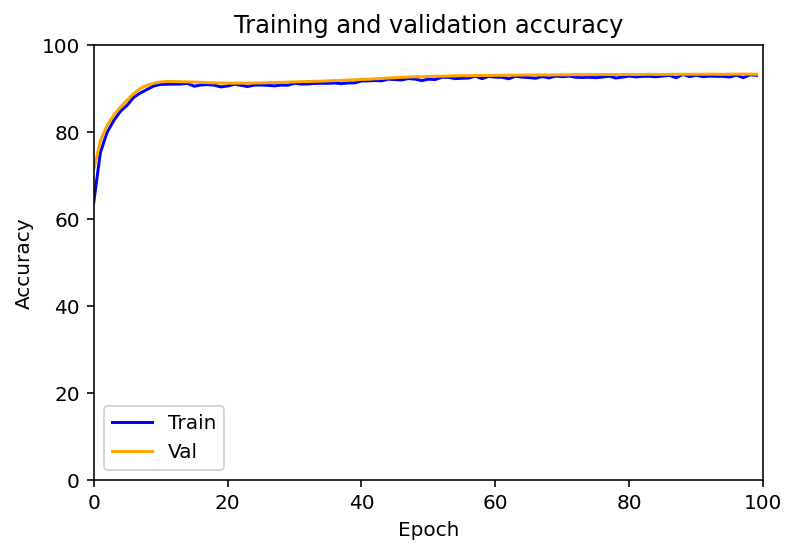

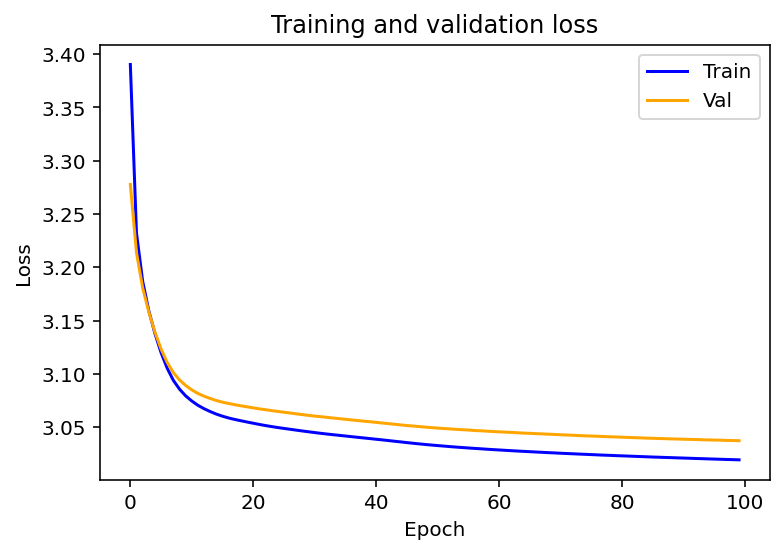

In [58]:
plt.title('Training and validation accuracy')

plt.plot(range(len(gpd_acc[0])), np.mean(gpd_train_acc, axis= 0), color='blue', label='Train')
plt.plot(range(len(gpd_val_acc[0])), np.mean(gpd_val_acc, axis= 0), color='orange', label='Val')
plt.ylim(0, 100);
plt.xlim(0, 100);
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(gpd_train_loss[0])), np.mean(gpd_train_loss, axis= 0), color='blue', label='Train')
plt.plot(range(len(gpd_val_loss[0])), np.mean(gpd_val_loss, axis= 0), color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
lognorm_train_acc, lognorm_val_acc, lognorm_train_loss, lognorm_val_loss, lognorm_acc_iter, lognorm_val_acc_iter, lognorm_loss_iter, lognorm_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 4, n_components= 2, X_dat= X_sizes_train, y_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                      y_val_dat= y_sizes_val, fire_tag= 'size', func_flag= 'lognorm')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire size MDN with lognorm loss function


 20%|██        | 1/5 [00:37<02:28, 37.17s/it]

Validation iteration 2 for fire size MDN with lognorm loss function


 40%|████      | 2/5 [01:08<01:41, 33.67s/it]

Validation iteration 3 for fire size MDN with lognorm loss function


 60%|██████    | 3/5 [01:41<01:06, 33.26s/it]

Validation iteration 4 for fire size MDN with lognorm loss function


 80%|████████  | 4/5 [02:12<00:32, 32.45s/it]

Validation iteration 5 for fire size MDN with lognorm loss function


100%|██████████| 5/5 [02:43<00:00, 32.67s/it]


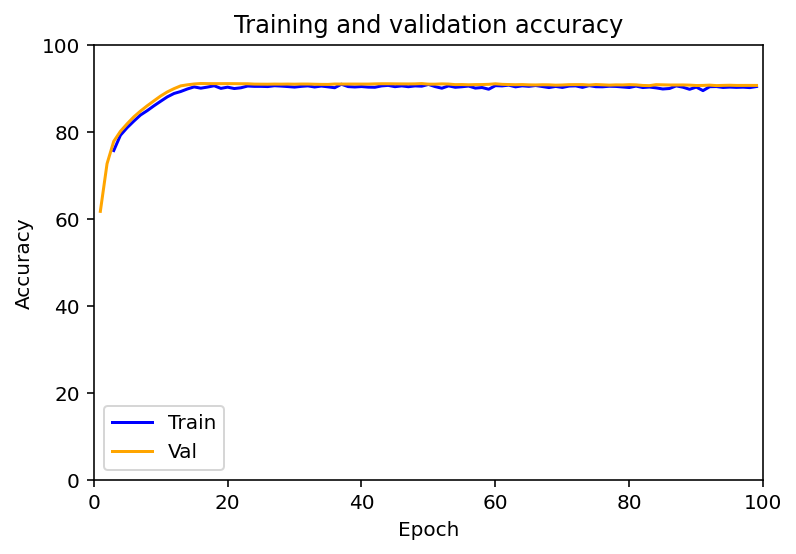

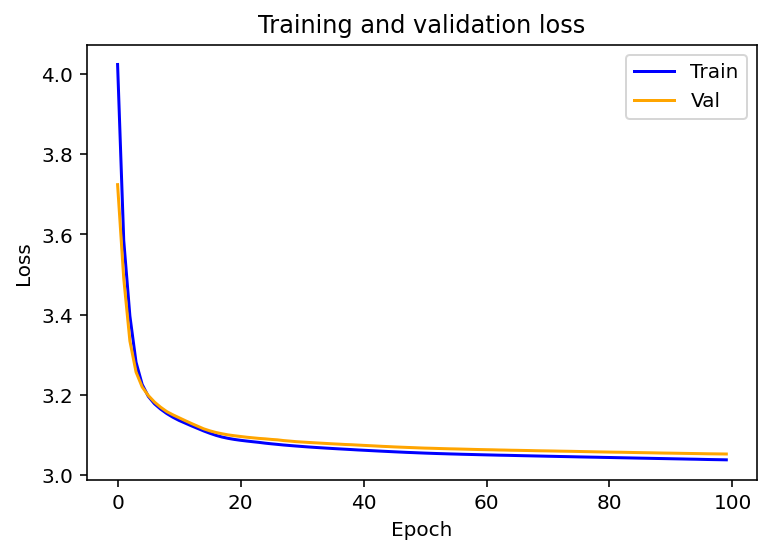

In [59]:
plt.title('Training and validation accuracy')

plt.plot(range(len(lognorm_acc[0])), np.mean(lognorm_train_acc, axis= 0), color='blue', label='Train')
plt.plot(range(len(lognorm_val_acc[0])), np.mean(lognorm_val_acc, axis= 0), color='orange', label='Val')
plt.ylim(0, 100);
plt.xlim(0, 100);
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(lognorm_train_loss[0])), np.mean(lognorm_train_loss, axis= 0), color='blue', label='Train')
plt.plot(range(len(lognorm_val_loss[0])), np.mean(lognorm_val_loss, axis= 0), color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Fire frequency

In [50]:
zinb_train_acc, zinb_val_acc, zinb_train_loss, zinb_val_loss, zinb_acc_iter, zinb_val_acc_iter, zinb_loss_iter, zinb_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 16, X_dat= X_freqs_train, y_dat= y_freqs_train, X_val_dat= X_freqs_val, \
                      y_val_dat= y_freqs_val, fire_tag= 'freq', func_flag= 'zinb')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire freq MDN with zinb loss function


 20%|██        | 1/5 [00:15<01:00, 15.16s/it]

Validation iteration 2 for fire freq MDN with zinb loss function


 40%|████      | 2/5 [00:28<00:43, 14.38s/it]

Validation iteration 3 for fire freq MDN with zinb loss function


 60%|██████    | 3/5 [00:42<00:27, 13.88s/it]

Validation iteration 4 for fire freq MDN with zinb loss function


 80%|████████  | 4/5 [00:56<00:13, 13.82s/it]

Validation iteration 5 for fire freq MDN with zinb loss function


100%|██████████| 5/5 [01:09<00:00, 13.93s/it]


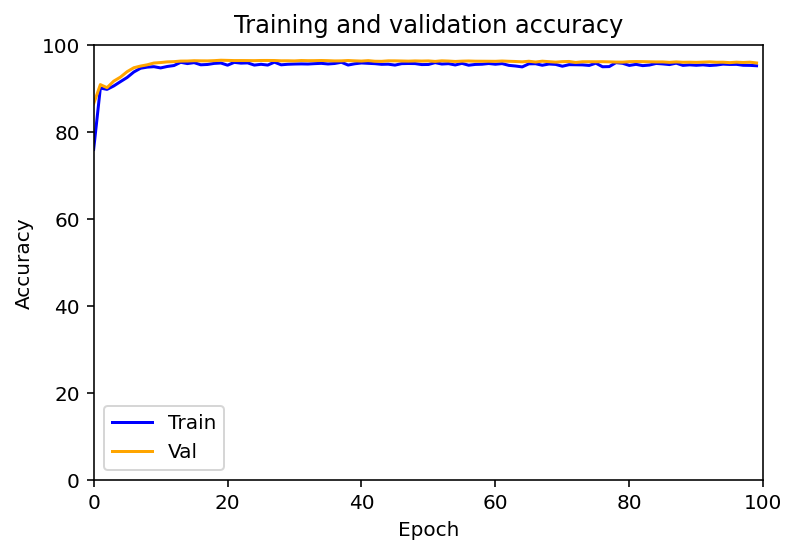

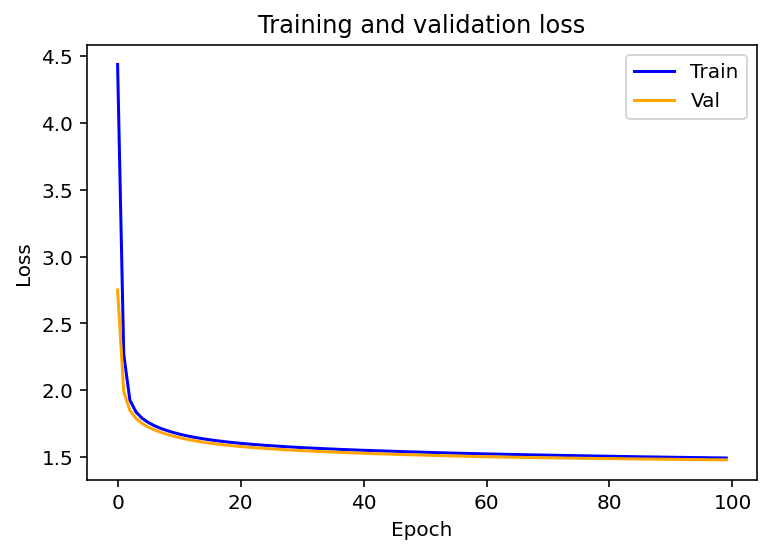

In [63]:
plt.title('Training and validation accuracy')

plt.plot(range(len(zinb_acc[0])), np.mean(zinb_train_acc, axis= 0), color='blue', label='Train')
plt.plot(range(len(zinb_val_acc[0])), np.mean(zinb_val_acc, axis= 0), color='orange', label='Val')
plt.ylim(0, 100);
plt.xlim(0, 100);
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(zinb_train_loss[0])), np.mean(zinb_train_loss, axis= 0), color='blue', label='Train')
plt.plot(range(len(zinb_val_loss[0])), np.mean(zinb_val_loss, axis= 0), color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
zipd_train_acc, zipd_val_acc, zipd_train_loss, zipd_val_loss, zipd_acc_iter, zipd_val_acc_iter, zipd_loss_iter, zipd_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 16, X_dat= X_freqs_train, y_dat= y_freqs_train, X_val_dat= X_freqs_val, \
                      y_val_dat= y_freqs_val, fire_tag= 'freq', func_flag= 'zipd')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire freq MDN with zipd loss function


 20%|██        | 1/5 [00:12<00:49, 12.42s/it]

Validation iteration 2 for fire freq MDN with zipd loss function


 40%|████      | 2/5 [00:25<00:37, 12.58s/it]

Validation iteration 3 for fire freq MDN with zipd loss function


 60%|██████    | 3/5 [00:37<00:24, 12.46s/it]

Validation iteration 4 for fire freq MDN with zipd loss function


 80%|████████  | 4/5 [00:49<00:12, 12.35s/it]

Validation iteration 5 for fire freq MDN with zipd loss function


100%|██████████| 5/5 [01:02<00:00, 12.44s/it]


### 3.3 Testing

Finally, we use our trained MDNs to predict the fire sizes and frequencies using the test data set and compare these with the corresponding observed values.

In [29]:
reg_ml_freq_df, h_freq= reg_fire_freq_func(X_train_dat= X_freqs_train, y_train_dat= y_freqs_train, X_val_dat= X_freqs_val, y_val_dat= y_freqs_val, X_test_dat= X_freqs_test)
reg_ml_freq_groups= reg_ml_freq_df.groupby('reg_indx')

MDN trained for 134 epochs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 22.32it/s]


In [104]:
tot_months= 60
n_regions= 18

month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 
freq_test_size= np.int(len(y_freqs_test)/n_regions)
freq_arr_1= np.linspace(0, len(y_freqs_test) - freq_test_size, n_regions, dtype= int)
freq_arr_2= freq_arr_1 + freq_test_size

ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 15], [16, 17, 18]]
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", 15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

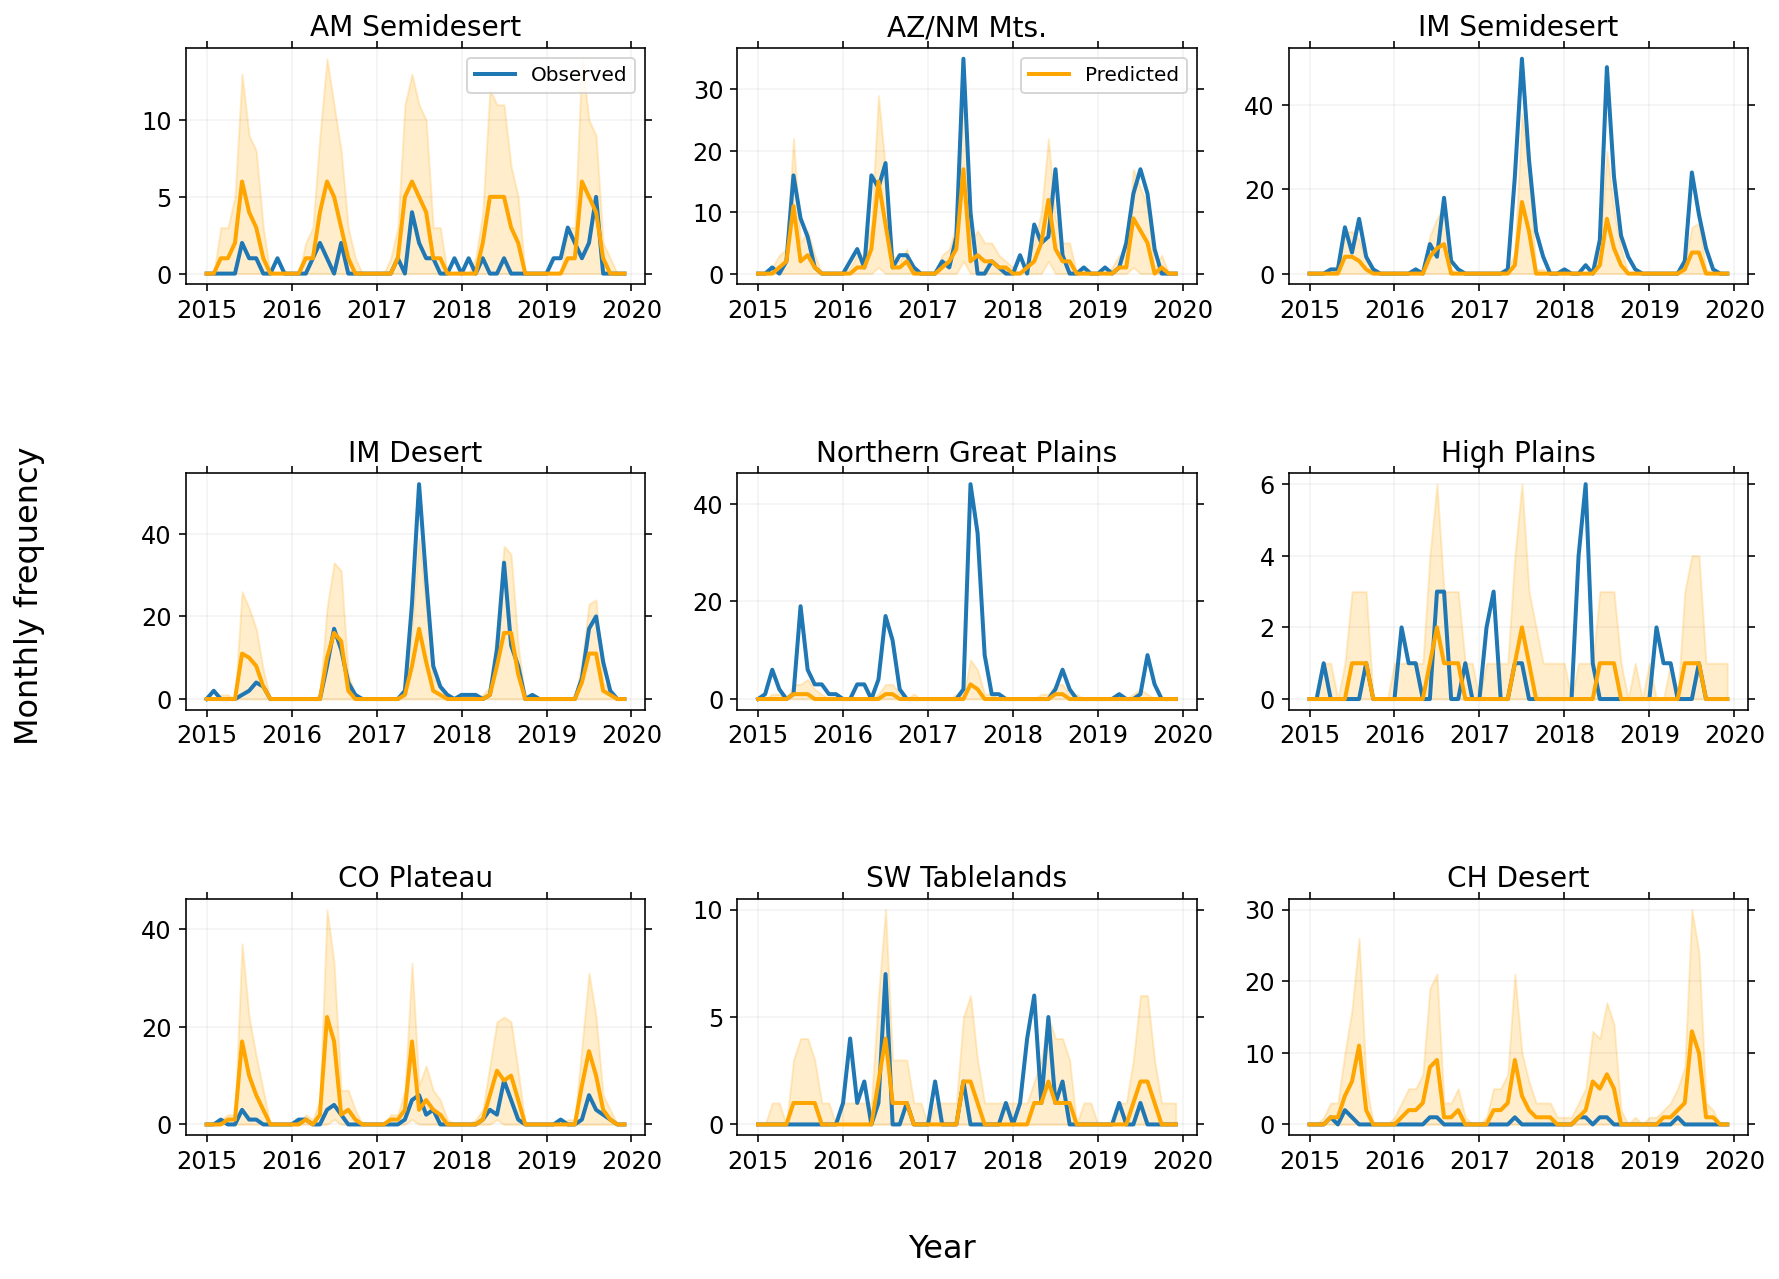

In [126]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, y_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, y_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_freq_groups.get_group(regindx)['high_1sig_freq'], reg_ml_freq_groups.get_group(regindx)['low_1sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
        

#plt.savefig('../plots/ml_fire_freq_2.pdf', bbox_inches='tight');

In [116]:
def reg_fire_size_func(X_train_dat, y_train_dat, X_val_dat, y_val_dat, X_test_dat, y_test_dat, func_flag= 'gpd', freq_flag= 'ml', freqs_data= None):
    
    # Calculates the predicted fire burned areas as well as its 1 sigma uncertainty for all regions
    
    tf.random.set_seed(77)

    if func_flag == 'gpd':
        n_layers= 2
        n_neurons= 16
        n_comps= 3
        stat_model= gpd_model
        loss_func= gpd_loss
        acc_func= gpd_accuracy
         
    elif func_flag == 'lognorm':
        n_layers= 2
        n_neurons= 4
        n_comps= 2
        stat_model= lognorm_model
        loss_func= lognorm_loss
        acc_func= lognorm_accuracy
        
    es_mon = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    mdn= MDN_size(layers= 2, neurons= 16, components= 3)
    mdn.compile(loss=loss_func, optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=[acc_func])
    h= mdn.fit(x= X_train_dat, y= y_train_dat, epochs=500, validation_data=(X_val_dat, y_val_dat), callbacks= [es_mon], batch_size= 128, verbose=0)
    print("MDN trained for %d epochs"%len(h.history['loss']))
    
    n_regions= 18
    tot_months= 60
    reg_size_df= pd.DataFrame({'mean_size': pd.Series(dtype= 'int'), 'low_1sig_size': pd.Series(dtype= 'int'), 'high_1sig_size': pd.Series(dtype= 'int'), 'obs_size': pd.Series(dtype= 'float'),\
                                                                                       'reg_indx': pd.Series(dtype= 'int')})
    
    for i in tqdm(range(n_regions)): 
        reg_freqs= reg_ml_freq_groups.get_group(i+1)
        size_ind_df= fire_size_test.reset_index()[['fire_size', 'month', 'reg_indx']]
        reg_ind_df= size_ind_df.groupby('reg_indx').get_group(i+1).groupby('month')
        
        obs_burnarea_arr= np.zeros(tot_months)
        mean_burnarea_tot= np.zeros(tot_months)
        high_1sig_burnarea_tot= np.zeros(tot_months)
        low_1sig_burnarea_tot= np.zeros(tot_months)

        for m in range(tot_months):
            mindx= m + 372
            if freq_flag == 'ml':
                freqs= reg_freqs['mean_freq'].iloc[[m]].to_numpy()[0]
            elif freq_flag == 'data':
                freq_size= np.int(len(freqs_data)/n_regions)
                tmparr_1= np.linspace(0, len(freqs_data) - freq_size, n_regions, dtype= int)
                #tmparr_2= tmparr_1 + freq_size
                freqs= freqs_data.astype(int)[tmparr_1[i] + m]
            
            try:
                fire_ind_arr= reg_ind_df.get_group(mindx).index.to_numpy()
                obs_burnarea_arr[m]= np.sum(y_test_dat[fire_ind_arr])
                
                if freqs == 0:
                    mean_burnarea_tot[m]= 0
                    high_1sig_burnarea_tot[m]= 0
                    low_1sig_burnarea_tot[m]= 0
                else:
                    ml_param_vec= mdn.predict(x= X_test_dat[fire_ind_arr]) 
                    #print(len(ml_param_vec))
                    mean_size_arr= tf.reduce_mean(stat_model(ml_param_vec).sample(1000), axis= 0).numpy()
                    std_size_arr= tf.math.reduce_std(stat_model(ml_param_vec).sample(1000), axis= 0).numpy()
                    if freqs < len(fire_ind_arr):
                        rindx= np.random.choice(np.arange(len(mean_size_arr)), freqs, replace=True)
                        mean_burnarea_tot[m]= np.sum(mean_size_arr[rindx])
                        high_1sig_burnarea_tot[m]= abs(np.sum(mean_size_arr[rindx] + std_size_arr[rindx]))
                        if (np.sum(mean_size_arr[rindx] - std_size_arr[rindx])) < 0: 
                            low_1sig_burnarea_tot[m]= 0 
                    else:
                        rindx= np.random.choice(len(mean_size_arr))
                        mean_burnarea_tot[m]= freqs*mean_size_arr[rindx]
                        high_1sig_burnarea_tot[m]= abs(freqs*(mean_size_arr[rindx] + std_size_arr[rindx]))
                        if (np.sum(mean_size_arr[rindx] - std_size_arr[rindx])) < 0:
                            low_1sig_burnarea_tot[m]= 0 
            
            except KeyError:
                    obs_burnarea_arr[m]= 0
                    mean_burnarea_tot[m]= 0 #current kludge and needs to be fixed
                    high_1sig_burnarea_tot[m]= 0
                    low_1sig_burnarea_tot[m]= 0
        
        reg_indx_arr= (i+1)*np.ones(tot_months, dtype= int)
        reg_size_df= reg_size_df.append(pd.DataFrame({'mean_size': mean_burnarea_tot, 'low_1sig_size': low_1sig_burnarea_tot, 'high_1sig_size': high_1sig_burnarea_tot, 'obs_size': obs_burnarea_arr, \
                                                                                       'reg_indx': reg_indx_arr}), ignore_index=True)
    
    return reg_size_df, h

In [117]:
reg_ml_size_df, h_size= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, X_test_dat= X_sizes_test, y_test_dat= y_sizes_test, func_flag= 'gpd', freq_flag= 'ml')
#reg_data_size_df, h_size= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, X_test_dat= X_sizes_test, y_test_dat= y_sizes_test, func_flag= 'gpd', \
#                                                                                                                                                                                    freq_flag= 'data', freqs_data= y_freqs_test)
reg_ml_size_groups= reg_ml_size_df.groupby('reg_indx')

MDN trained for 301 epochs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.76it/s]


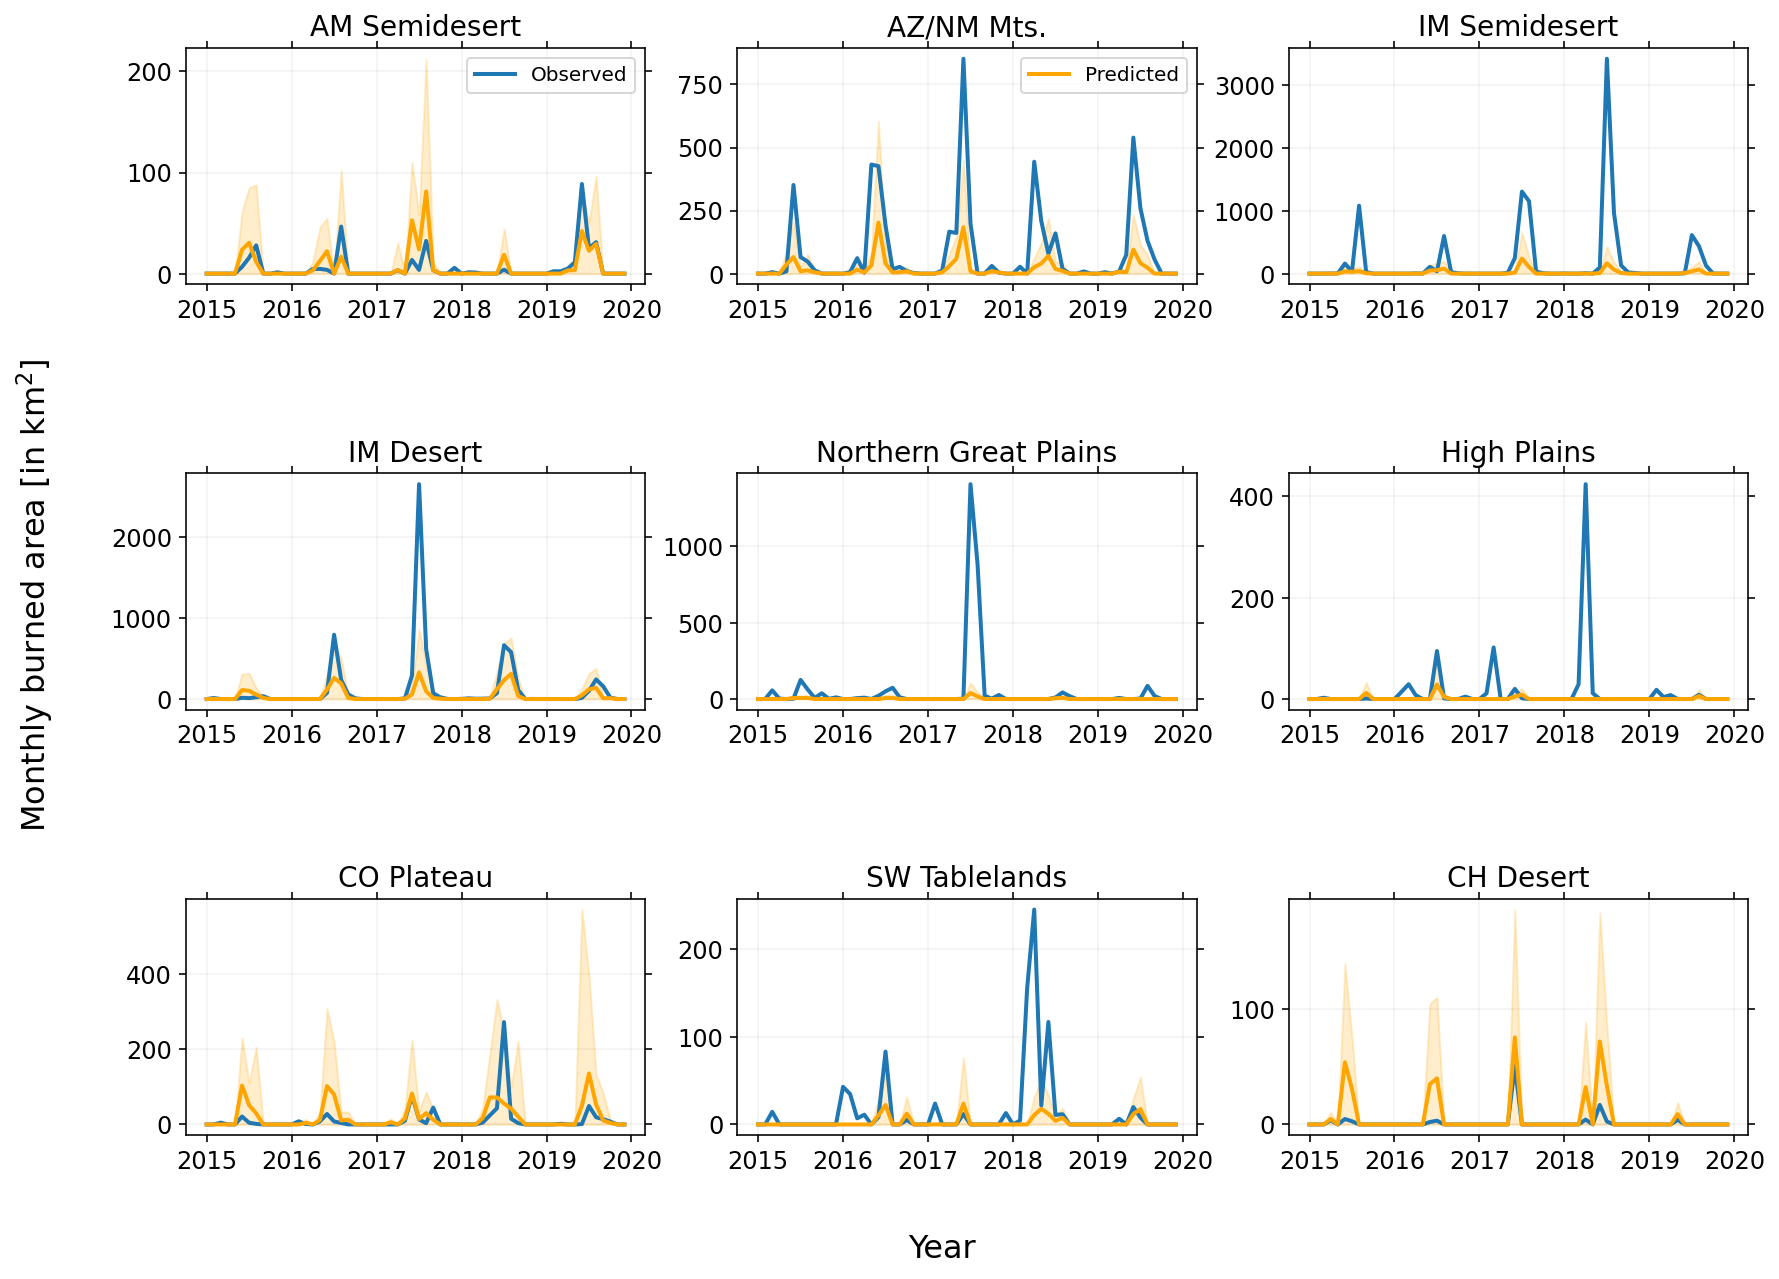

In [128]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['obs_size'], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['obs_size'], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
        

#plt.savefig('../plots/ml_fire_size_2.pdf', bbox_inches='tight');

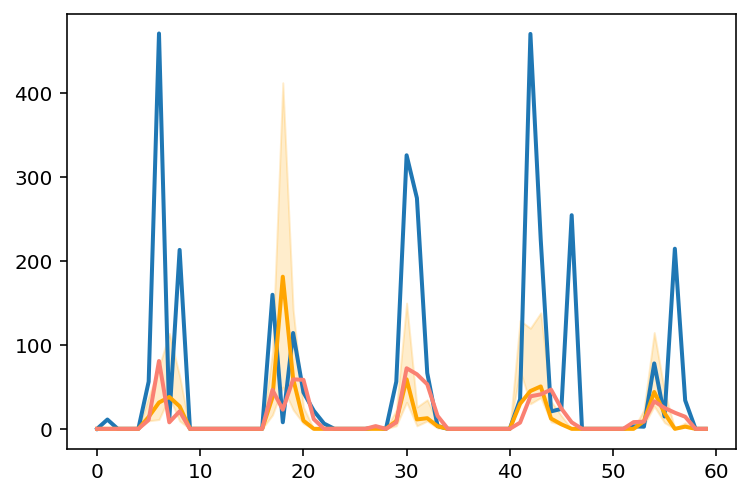

In [100]:
plt.plot(np.linspace(0, 59, 60), reg_ml_size_df['obs_size'], lw=2);
plt.plot(np.linspace(0, 59, 60), reg_ml_size_df['mean_size'], color= 'orange', lw= 2)
plt.plot(np.linspace(0, 59, 60), reg_data_size_df['mean_size'], color= 'salmon', lw= 2)
#plt.plot(np.linspace(0, 59, 60), 20*y_freqs_test[0:60], color= 'black', lw=2)
#plt.plot(np.linspace(0, 59, 60), 20*reg_ml_freq_groups.get_group(1)['mean_freq'], color= 'green', lw= 2)
plt.fill_between(np.linspace(0, 59, 60), reg_ml_size_df['high_1sig_size'], reg_ml_size_df['low_1sig_size'], color= 'orange', alpha=0.2);
#plt.ylim(0, 25);

### Results on a Map

## Future extensions

### Training with Cross-Validation

In [ ]:
from sklearn.model_selection import KFold # import KFold
n = 10
kf = KFold(n_splits=n) # Define the split - into 20 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=n, random_state=None, shuffle=False)

KFold(n_splits=10, random_state=None, shuffle=False)


KFold(n_splits=10, random_state=None, shuffle=False)

TRAIN: [ 12163  12164  12165 ... 121623 121624 121625] VAL: [    0     1     2 ... 12160 12161 12162]
Epoch: 1 Current training accuracy: 5.5247 Validation Accuracy: 45.8579 Validation Loss 1.341586
Epoch: 2 Current training accuracy: 5.3518 Validation Accuracy: 61.2451 Validation Loss 1.338930
Epoch: 3 Current training accuracy: 31.9964 Validation Accuracy: 56.4964 Validation Loss 1.338897
Epoch: 4 Current training accuracy: -189.4782 Validation Accuracy: 70.2967 Validation Loss 1.339864
Epoch: 5 Current training accuracy: 20.6566 Validation Accuracy: 66.0470 Validation Loss 1.338674
Epoch: 6 Current training accuracy: 16.0725 Validation Accuracy: 76.8410 Validation Loss 1.334993
Epoch: 7 Current training accuracy: 13.3910 Validation Accuracy: 72.9327 Validation Loss 1.337904
Epoch: 8 Current training accuracy: 67.9828 Validation Accuracy: 78.0739 Validation Loss 1.339003
Epoch: 9 Current training accuracy: 4.5992 Validation Accuracy: 86.6286 Validation Loss 1.341184
Epoch: 10 Current

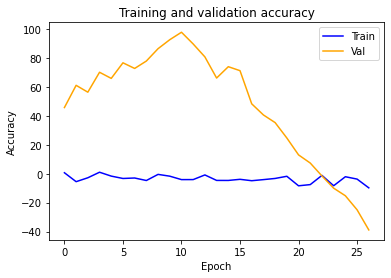

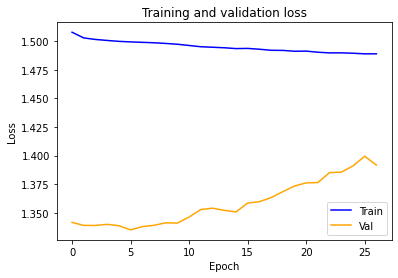

IndexError: ignored

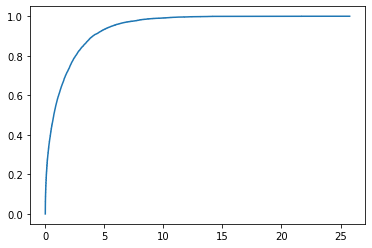

In [ ]:
Acc_List = []
Val_Acc_List = []
Loss_List = []
Val_Loss_List = []


Accuracy_val = []
AIC_val = []
MAE_val = []


for train_index, val_index in kf.split(X):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    h = Network(batch_size = 100, m=1, n_neurons=3, n_hidden_layers=2, n_epochs=30, batch_norm_momentum = True, activation=tf.nn.relu, initializer=he_init, learning_rate=0.001)
    
    h.fit(X_train,y_train,X_val,y_val)
    acc_list, val_acc_list, loss_list, val_loss_list = h.__get_list__()

    Acc_List.append(acc_list)
    Val_Acc_List.append(val_acc_list)
    Loss_List.append(loss_list)
    Val_Loss_List.append(val_loss_list)
    
    acc_val, aic_val, mae_val = h.evaluate(X_val,y_val)
    Accuracy_val.append(acc_val)
    AIC_val.append(aic_val)
    MAE_val.append(mae_val)
    


print('Validation Accuracy: ', np.nanmean(Accuracy_val))
print('Validation AIC: ', np.nanmean(AIC_val))
print('Validation MAE: ', np.nanmean(MAE_val))

    

IndexError: ignored

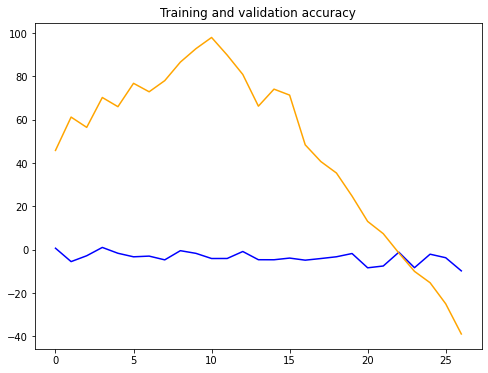

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.title('Training and validation accuracy')

plt.plot(range(len(Acc_List[0])), Acc_List[0], color='blue', label='Train')
plt.plot(range(len(Val_Acc_List[0])), Val_Acc_List[0], color='orange', label='Val')

for i in range(1, n):
    plt.plot(range(len(Acc_List[i])), Acc_List[i], color='blue')
    plt.plot(range(len(Val_Acc_List[i])), Val_Acc_List[i], color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(Loss_List[0])), Loss_List[0], color='blue', label='Train')
plt.plot(range(len(Val_Loss_List[0])), Val_Loss_List[0], color='orange', label='Val')

for i in range(1, n):
    plt.plot(range(len(Loss_List[i])), Loss_List[i], color='blue')
    plt.plot(range(len(Val_Loss_List[i])), Val_Loss_List[i], color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Validation Accuracies 

ValAccuracies = []
#ValMAE = []

for i in range(n):
    l = Val_Acc_List[i]
    ValAccuracies.append(l[-1])
    #l2 = Val_Mae_List[i]
    #ValMAE.append(l[-1])

print("Evolution of the Validation Accuracies during Cross-Validation Training: ", ValAccuracies)
print("Final Accuracy of the model: ", np.nanmean(ValAccuracies))
#print("Evolution of the Validation MAE during Cross-Validation Training: ", ValMAE)
#print("Final MAE of the model: ", np.nanmean(ValMAE))

IndexError: ignored

### Fire occurrence prediction with Random Forest

We use a random forest classifier to predict if a fire occurs or not. This is a binary classification problem: the model outputs 1 if a fire occurs and 0 otherwise.

In [4]:
df.head()

,forest,urban,solar,year,month,prec,tmin,wind,burnarea,vpd,deltaT
0,0.187001,0.215967,44.11,1984,1,152.60,2.29,1.89,0.0,1.74,5.00
1,0.187001,0.215967,68.95,1984,2,120.27,3.86,2.08,0.0,2.28,5.20
2,0.187001,0.215967,125.80,1984,3,91.87,4.84,1.43,0.0,2.77,6.61
3,0.187001,0.215967,193.24,1984,4,81.51,5.09,1.88,0.0,3.71,7.30
4,0.187001,0.215967,217.10,1984,5,105.18,7.17,1.55,0.0,3.94,7.30


In [5]:
df.shape

(29015280, 11)

In [6]:
df['occurrence'] = np.where(df['burnarea']>0, 1, 0)

In [7]:
y = np.array(df.occurrence)
X = df[['year','month','solar', 'prec', 'deltaT', 'tmin', 'vpd', 'wind','forest','urban']]
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
X = np.array(X, dtype=np.float32)

### RF on imbalanced dataset with re-balance option

In [8]:
rf_w = RandomForestClassifier(n_estimators = 50, random_state = 42, class_weight="balanced", criterion = "entropy")

In [9]:
dfs = df.sample(frac=0.1)
ys = np.array(dfs.occurrence)
Xs = dfs[['solar', 'prec', 'deltaT', 'tmin', 'vpd', 'wind','forest','urban']]
minmax_scaler = MinMaxScaler()
Xs = minmax_scaler.fit_transform(Xs)
Xs = np.array(Xs, dtype=np.float32)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(Xs, ys, test_size=0.3, random_state=42)

In [11]:
rf_w.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
# Use the forest's predict method on the test data
predictions = rf_w.predict(X_val)
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

Mean Absolute Error: 0.001854 degrees.


In [13]:
pscore = metrics.accuracy_score(y_val, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predictions)
print("recall: ", recall)

accuracy:  0.998145805833474
f1 score:  0.1815415821501014
recall:  0.10257879656160458


In [14]:
cf = confusion_matrix(y_val, predictions)
cf

array([[868666,     48],
       [  1566,    179]])

### RF on rebalanced dataset to 30% fires (occurrence = 1) and 70% no fire

In [15]:
df1 = df[df['occurrence']==1]
n1 = len(df1)

In [16]:
n2 = 7*n1/3
df2 = df[df['occurrence']==0]
df2 = df2.sample(n = int(n2))

In [17]:
df_r = pd.concat([df1, df2], sort =False)

In [18]:
y_r = np.array(df_r.occurrence)

In [19]:
#took out relative humidity ('rh') because I did not have time to include it 
X_r = df_r[['year','month','solar', 'prec', 'deltaT', 'tmin', 'vpd', 'wind','forest','urban' ]] #'solar', 'prec', 'deltaT', 'tmin','wind','forest','urban'

In [20]:
minmax_scaler = MinMaxScaler()
X_r = minmax_scaler.fit_transform(X_r)
X_r = np.array(X_r, dtype=np.float32)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_r, y_r, test_size=0.3, random_state=42)

#### Training

In [22]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [23]:
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### Testing on validation set

In [24]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')


Mean Absolute Error: 0.035756 degrees.


In [25]:
pscore = metrics.accuracy_score(y_val, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predictions)
print("recall: ", recall)

accuracy:  0.9642441909447824
f1 score:  0.9419393674072453
recall:  0.9754065846886156


In [26]:
cf = confusion_matrix(y_val, predictions)
cf

array([[40012,  1688],
       [  434, 17213]])

#### Testing on real dataset

In [27]:
# Use the forest's predict method on the test data
predictions = rf.predict(X)
# Calculate the absolute errors
errors = abs(predictions - y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

Mean Absolute Error: 0.041178 degrees.


In [28]:
pscore = metrics.accuracy_score(y, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y, predictions)
print("recall: ", recall)

accuracy:  0.9588218000998094
f1 score:  0.06993270462037855
recall:  0.7568874585067484


In [29]:
cf = confusion_matrix(y, predictions)
cf

array([[27775564,  1180369],
       [   14428,    44919]])

#### Variable Importance

In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction. The actual calculation of the importance is beyond the scope of this post, but we can use the numbers to make relative comparisons between variables.

In [30]:
feature_list = ['year','month','solar', 'prec', 'deltaT', 'tmin', 'vpd', 'wind','forest','urban']
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))


Variable: vpd                  Importance: 0.2743
Variable: solar                Importance: 0.1479
Variable: tmin                 Importance: 0.1233
Variable: prec                 Importance: 0.1084
Variable: deltaT               Importance: 0.0738
Variable: forest               Importance: 0.0696
Variable: month                Importance: 0.0609
Variable: year                 Importance: 0.0588
Variable: wind                 Importance: 0.05
Variable: urban                Importance: 0.033


We use a bar plot for the feature importances to illustrate the disparities in the relative significance of the variables. 

Text(0.5, 1.0, 'Variable Importance')

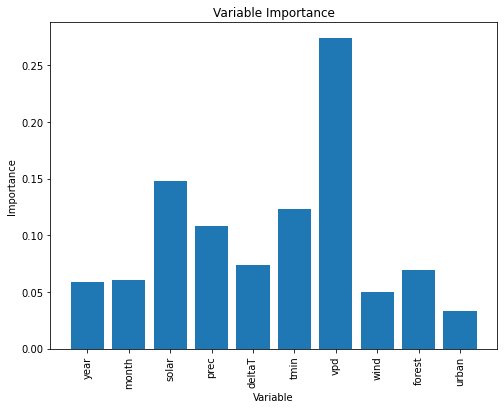

In [31]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance')